# featureCounts Compare Genome vs Transcriptome for DMS samples: Madrasin + Controls

## Purpose

This were read counts generated by the program featureCounts After STAR alignment

Aim of this script is to get the ratio of Genomic reads to Transcriptomic reads for samples that were treated with DMS 

We want to see how the ratio changes as you add varying concentrations of Madrasin

In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

In [2]:
# Set variable to find highly expressed genes or transcripts
feature="Gene"

In [3]:
# Set variable to remove non-coding genes
removeNC=True
removeNC_string=""
if removeNC:
    removeNC_string="Coding"
    geneNamesAndTranscriptIDs = pd.read_csv("../data/GeneNameTranscriptID_NCBI_RefSeq_hg38_FromGFFfile.tsv",header=None,sep="\t")
    noncodinggeneNames= list(geneNamesAndTranscriptIDs[geneNamesAndTranscriptIDs[0].str.contains("NR_")|geneNamesAndTranscriptIDs[0].str.contains("XR_")][1].values)
    noncodingtranscriptNames= list(geneNamesAndTranscriptIDs[geneNamesAndTranscriptIDs[0].str.contains("NR_")|geneNamesAndTranscriptIDs[0].str.contains("XR_")][0].values)
    noncodingFeatures = noncodinggeneNames+noncodingtranscriptNames

In [4]:
# Set variable to only look at features that have introns in them
featuresWithIntrons=True
featuresWithIntrons_string=""
if featuresWithIntrons:
    featuresWithIntrons_string="WithIntronicRegions"
    # Get the transcript and genes that have introns within them
    geneNamesAndTranscriptIDs_withIntrons = pd.read_csv("../data/GeneNameTranscriptID_NCBI_RefSeq_hg38_FromGFFfile_OnlyOnesWithIntrons.tsv",header=None,sep="\t")
    print geneNamesAndTranscriptIDs_withIntrons.shape
    geneNamesAndTranscriptIDs_withIntrons.head()

(153118, 2)


In [5]:
# Set variable to determine how many expressed features to look at
# If set to 0, then get all features
numFeatures=50

In [6]:
# Get highly expressed features from each file for the transcriptome data
top_features_Transcriptome = []
for filename in os.listdir("../tmp/Lela_MadrasinReadsTest_June2018/"):
    if ("Transcriptome_featureCounts_JustCounts.txt" in filename) and (("DMS" in filename and "Mad-30mm-8hr-DMS" not in filename) or ("Mad-30mm-8hr-minus" in filename) or ("All_DMS" in filename)):
        print filename
        # Read the salmon output file
        with open("../tmp/Lela_MadrasinReadsTest_June2018/"+filename) as f:
            lines = f.readlines()
        with open("../tmp/Lela_MadrasinReadsTest_June2018/"+filename.split('.')[0]+"_DropHeader.txt",'w') as fw:
            fw.writelines(lines[1:])
        data_to_read = pd.read_csv("../tmp/Lela_MadrasinReadsTest_June2018/"+filename.split('.')[0]+"_DropHeader.txt",header=0,sep="\t")
        data_to_read.columns = ["Name","Length","Count"]
        # If features with Introns flag is set, only get features that have introns in them
        if featuresWithIntrons:
            # Only features with introns
            data_to_read = data_to_read[(data_to_read["Name"].isin(geneNamesAndTranscriptIDs_withIntrons[0])|data_to_read["Name"].isin(geneNamesAndTranscriptIDs_withIntrons[1]))]
        # If removeNC flag is set, only get coding features
        if removeNC:
            data_to_read = data_to_read[~(data_to_read["Name"].str.contains("NR_")|data_to_read["Name"].str.contains("XR_")|data_to_read["Name"].isin(noncodingFeatures))]
        # Calculate TPMs
        RPKs = 1000*(data_to_read["Count"]/data_to_read["Length"])
        total_RPKs = RPKs.sum()
        TPMs = 1000000*(RPKs/total_RPKs)
        data_to_read = data_to_read.assign(TPM=TPMs)
        # Sort the data by TPMs
        data_to_read_sorted = data_to_read.sort_values(by=["TPM"],ascending=False)
        # Grab the names of the first numFeatures features
        if numFeatures==0:
            top_features_Transcriptome.extend(list(data_to_read_sorted["Name"].values))
        else:
            top_features_Transcriptome.extend(list(data_to_read_sorted.iloc[range(numFeatures),0].values))

Mad-10mm-4hr-DMS_S1_Transcriptome_featureCounts_JustCounts.txt
All_DMSfiles_Transcriptome_featureCounts_JustCounts.txt
Mad-20mm-4hr-DMS_S2_Transcriptome_featureCounts_JustCounts.txt
Mad-30mm-8hr-minus_S12_Transcriptome_featureCounts_JustCounts.txt
Mad-20mm-8hr-DMS_S8_Transcriptome_featureCounts_JustCounts.txt
Mad-30mm-4hr-DMS_S3_Transcriptome_featureCounts_JustCounts.txt
Mad-10mm-8hr-DMS_S7_Transcriptome_featureCounts_JustCounts.txt


In [7]:
# Combine the two feature files together to get a unique list
unique_top_features = list(set(top_features_Transcriptome))
print(len(unique_top_features))

66


In [8]:
# Create a data frame with unique top features as column
feature_readCounts_transcriptome = pd.DataFrame({"feature":sorted(unique_top_features)})
# For the unique features, get the TPM for each of them and store in a data frame
# Read in the Count files 
for filename in os.listdir("../tmp/Lela_MadrasinReadsTest_June2018/"):
    current_columns = list(feature_readCounts_transcriptome.columns.values)
    if ("Transcriptome_featureCounts_JustCounts_DropHeader.txt" in filename) and (("DMS" in filename and "Mad-30mm-8hr-DMS" not in filename) or ("Mad-30mm-8hr-minus" in filename) or ("All_DMS" in filename)):
        print filename
        current_columns.append(filename.split("_Transcriptome")[0])
        data_to_read = pd.read_csv("../tmp/Lela_MadrasinReadsTest_June2018/"+filename,header=0,sep="\t")
        data_to_read.columns = ["Name","Length","Count"]
        # Calculate TPMs
        RPKs = 1000*(data_to_read["Count"]/data_to_read["Length"])
        total_RPKs = RPKs.sum()
        TPMs = 1000000*(RPKs/total_RPKs)
        data_to_read = data_to_read.assign(TPM=TPMs)
        data_GetFeatures = data_to_read[data_to_read["Name"].isin(unique_top_features)]
        data_sortedBy_FeatureName = data_GetFeatures.sort_values(by="Name")
        data_sortedBy_FeatureName = data_sortedBy_FeatureName.reset_index(drop=True)
        feature_readCounts_transcriptome = pd.concat([feature_readCounts_transcriptome,data_sortedBy_FeatureName["TPM"]],axis=1,ignore_index=True)
        feature_readCounts_transcriptome.columns = current_columns

Mad-10mm-4hr-DMS_S1_Transcriptome_featureCounts_JustCounts_DropHeader.txt
Mad-30mm-8hr-minus_S12_Transcriptome_featureCounts_JustCounts_DropHeader.txt
Mad-20mm-4hr-DMS_S2_Transcriptome_featureCounts_JustCounts_DropHeader.txt
Mad-30mm-4hr-DMS_S3_Transcriptome_featureCounts_JustCounts_DropHeader.txt
All_DMSfiles_Transcriptome_featureCounts_JustCounts_DropHeader.txt
Mad-20mm-8hr-DMS_S8_Transcriptome_featureCounts_JustCounts_DropHeader.txt
Mad-10mm-8hr-DMS_S7_Transcriptome_featureCounts_JustCounts_DropHeader.txt


In [9]:
feature_readCounts_transcriptome = feature_readCounts_transcriptome.iloc[:,range(1,feature_readCounts_transcriptome.shape[1])]
feature_readCounts_transcriptome.index = sorted(unique_top_features)
print feature_readCounts_transcriptome.shape
feature_readCounts_transcriptome.head()

(66, 7)


,Mad-10mm-4hr-DMS_S1,Mad-30mm-8hr-minus_S12,Mad-20mm-4hr-DMS_S2,Mad-30mm-4hr-DMS_S3,All_DMSfiles,Mad-20mm-8hr-DMS_S8,Mad-10mm-8hr-DMS_S7
ACTB,8758.336651,7157.074448,7472.643651,7438.498399,7116.199038,7268.555823,6921.365860
ATP5F1B,614.705644,579.284788,604.439935,617.295664,1342.576675,676.925863,588.522020
CALR,807.189725,712.153100,892.242655,797.742396,1130.543069,795.974209,696.955304
CDKN1A,1407.787592,625.089583,586.247749,532.094661,993.043544,690.680752,2395.323610
CFL1,924.528093,744.895771,1150.249490,890.878490,1164.626700,931.894951,594.985596


In [10]:
# Create a data frame with unique top features as column
feature_readCounts_genome = pd.DataFrame({"feature":sorted(unique_top_features)})
# For the unique features, get the TPM for each of them and store in a data frame
# Read in the Count files 
for filename in os.listdir("../tmp/Lela_MadrasinReadsTest_June2018/"):
    current_columns = list(feature_readCounts_genome.columns.values)
    if ("Genome_featureCounts_JustCounts.txt" in filename) and (("DMS" in filename and "Mad-30mm-8hr-DMS" not in filename) or ("Mad-30mm-8hr-minus" in filename) or ("All_DMS" in filename)):
        print filename
        # Read the salmon output file
        with open("../tmp/Lela_MadrasinReadsTest_June2018/"+filename) as f:
            lines = f.readlines()
        with open("../tmp/Lela_MadrasinReadsTest_June2018/"+filename.split('.')[0]+"_DropHeader.txt",'w') as fw:
            fw.writelines(lines[1:])
        current_columns.append(filename.split("_Genome")[0])
        data_to_read = pd.read_csv("../tmp/Lela_MadrasinReadsTest_June2018/"+filename.split(".")[0]+"_DropHeader.txt",header=0,sep="\t")
        data_to_read.columns = ["Name","Length","Count"]
        # Calculate TPMs
        RPKs = 1000*(data_to_read["Count"]/data_to_read["Length"])
        total_RPKs = RPKs.sum()
        TPMs = 1000000*(RPKs/total_RPKs)
        data_to_read = data_to_read.assign(TPM=TPMs)
        data_GetFeatures = data_to_read[data_to_read["Name"].isin(unique_top_features)]
        data_sortedBy_FeatureName = data_GetFeatures.sort_values(by="Name")
        data_sortedBy_FeatureName = data_sortedBy_FeatureName.reset_index(drop=True)
        feature_readCounts_genome = pd.concat([feature_readCounts_genome,data_sortedBy_FeatureName["TPM"]],axis=1,ignore_index=True)
        feature_readCounts_genome.columns = current_columns

Mad-30mm-4hr-DMS_S3_Genome_featureCounts_JustCounts.txt
Mad-10mm-8hr-DMS_S7_Genome_featureCounts_JustCounts.txt
Mad-30mm-8hr-minus_S12_Genome_featureCounts_JustCounts.txt
Mad-20mm-4hr-DMS_S2_Genome_featureCounts_JustCounts.txt
Mad-20mm-8hr-DMS_S8_Genome_featureCounts_JustCounts.txt
All_DMSfiles_Genome_featureCounts_JustCounts.txt
Mad-10mm-4hr-DMS_S1_Genome_featureCounts_JustCounts.txt


In [11]:
feature_readCounts_genome = feature_readCounts_genome.iloc[:,range(1,feature_readCounts_genome.shape[1])]
feature_readCounts_genome.index = sorted(unique_top_features)
print feature_readCounts_genome.shape
feature_readCounts_genome.head()

(66, 7)


,Mad-30mm-4hr-DMS_S3,Mad-10mm-8hr-DMS_S7,Mad-30mm-8hr-minus_S12,Mad-20mm-4hr-DMS_S2,Mad-20mm-8hr-DMS_S8,All_DMSfiles,Mad-10mm-4hr-DMS_S1
ACTB,8145.344639,6787.904690,8414.406562,8160.481857,7541.346470,8014.063999,9139.192559
ATP5F1B,316.629297,254.165790,312.502262,298.457816,328.770872,663.064132,286.281118
CALR,531.636074,426.343496,513.928081,600.861556,532.965692,776.307764,508.712966
CDKN1A,394.417426,1581.418361,589.743864,488.006723,606.241166,749.391352,949.377870
CFL1,679.554999,442.497202,640.104719,892.740738,704.336222,928.693725,686.792567


In [12]:
# Let's get ratios of feature counts for transcriptomic vs genomic
ratios_readCounts = (feature_readCounts_genome)/(feature_readCounts_transcriptome)
print ratios_readCounts.shape
ratios_readCounts.head()

(66, 7)


,All_DMSfiles,Mad-10mm-4hr-DMS_S1,Mad-10mm-8hr-DMS_S7,Mad-20mm-4hr-DMS_S2,Mad-20mm-8hr-DMS_S8,Mad-30mm-4hr-DMS_S3,Mad-30mm-8hr-minus_S12
ACTB,1.126172,1.043485,0.980718,1.092048,1.037530,1.095025,1.175677
ATP5F1B,0.493874,0.465721,0.431871,0.493776,0.485682,0.512930,0.539462
CALR,0.686668,0.630227,0.611723,0.673428,0.669577,0.666426,0.721654
CDKN1A,0.754641,0.674376,0.660211,0.832424,0.877744,0.741254,0.943455
CFL1,0.797418,0.742857,0.743711,0.776128,0.755811,0.762792,0.859321


In [13]:
# Lets the average for every time point and concentration
ratios_readCounts_avg = ratios_readCounts.apply(np.mean,axis=0)
ratios_readCounts_avg

All_DMSfiles              0.671782
Mad-10mm-4hr-DMS_S1       0.612102
Mad-10mm-8hr-DMS_S7       0.583912
Mad-20mm-4hr-DMS_S2       0.680378
Mad-20mm-8hr-DMS_S8       0.666327
Mad-30mm-4hr-DMS_S3       0.670548
Mad-30mm-8hr-minus_S12    0.742011
dtype: float64

/usr/local/lib/python2.7/dist-packages/seaborn-0.8.1-py2.7.egg/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


['', 'All_DMSfiles', 'Mad-10mm-4hr-DMS_S1', 'Mad-10mm-8hr-DMS_S7', 'Mad-20mm-4hr-DMS_S2', 'Mad-20mm-8hr-DMS_S8', 'Mad-30mm-4hr-DMS_S3', 'Mad-30mm-8hr-minus_S12']


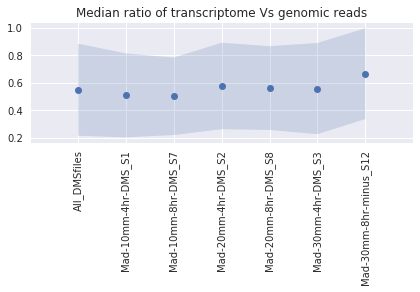

In [14]:
sns.set(font_scale=1)
ratios_readCounts_matrix = ratios_readCounts.values
ax = sns.tsplot(data=ratios_readCounts_matrix,estimator=np.median,interpolate=False, ci="sd")
labels_xaxis = list(ratios_readCounts_avg.index.values)
labels_xaxis.insert(0,"")
print labels_xaxis
ax.set_xticklabels(labels=labels_xaxis,rotation=90)
#plt.ylim(0, 0.5)
plt.tight_layout()
plt.title("Median ratio of transcriptome Vs genomic reads")
plt.savefig("../results/FeatureCounts_MedianRatio_TranscriptomeVsGenomicReads_PlusDMS_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")

['', 'All_DMSfiles', 'Mad-10mm-4hr-DMS_S1', 'Mad-10mm-8hr-DMS_S7', 'Mad-20mm-4hr-DMS_S2', 'Mad-20mm-8hr-DMS_S8', 'Mad-30mm-4hr-DMS_S3', 'Mad-30mm-8hr-minus_S12']


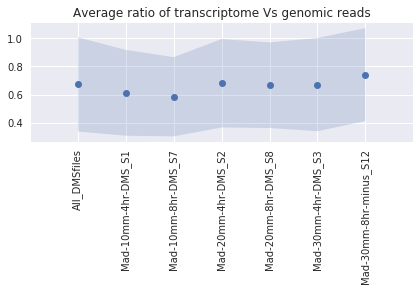

In [15]:
sns.set(font_scale=1)
ratios_readCounts_matrix = ratios_readCounts.values
ax = sns.tsplot(data=ratios_readCounts_matrix,estimator=np.mean,interpolate=False, ci="sd")
labels_xaxis = list(ratios_readCounts_avg.index.values)
labels_xaxis.insert(0,"")
print labels_xaxis
ax.set_xticklabels(labels=labels_xaxis,rotation=90)
#plt.ylim(0, 0.6)
plt.tight_layout()
plt.title("Average ratio of transcriptome Vs genomic reads")
plt.savefig("../results/FeatureCounts_MeanRatio_TranscriptomeVsGenomicReads_PlusDMS_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")

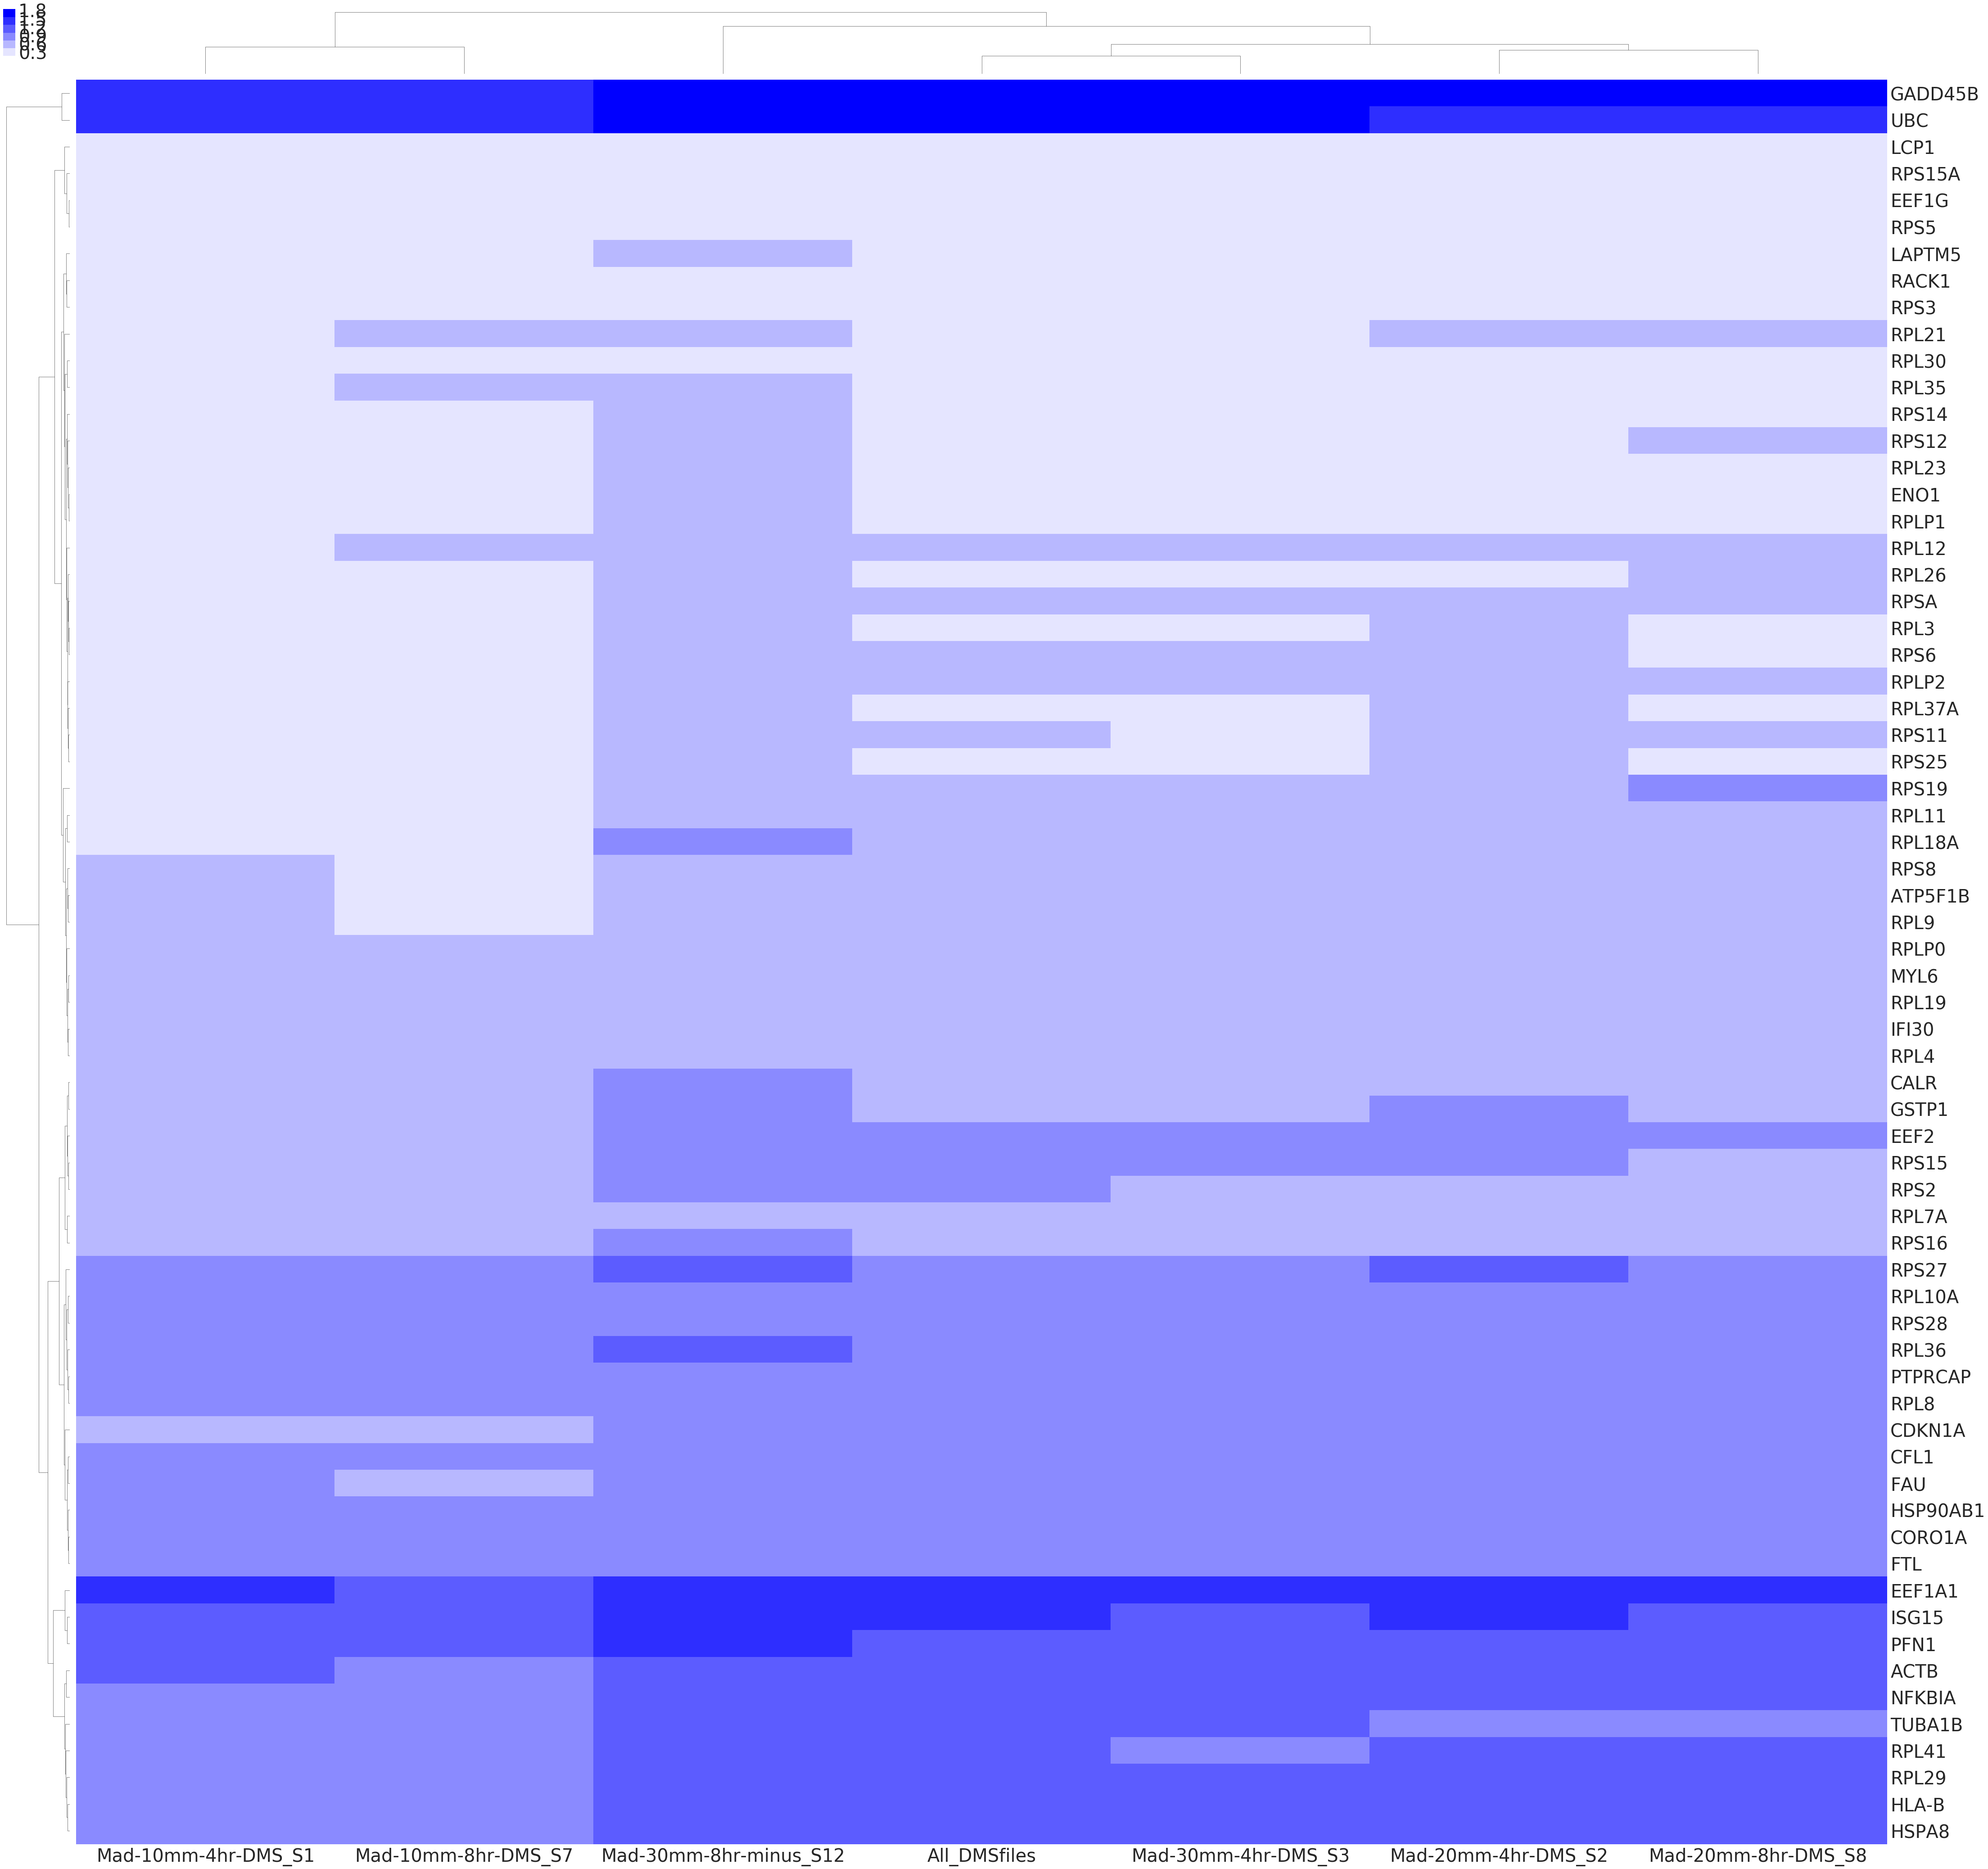

In [16]:
sns.set(font_scale=4)
ax = sns.clustermap(ratios_readCounts,cmap=sns.light_palette("blue"),annot=False, square=False, yticklabels=True, figsize=(75,75))
ax.savefig("../results/FeatureCounts_Ratio_TranscriptomeVsGenomicReads_PlusDMS_HeatMap_Clustered_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")
reordered_indices = ax.dendrogram_row.reordered_ind

In [17]:
labels_indices_org = ratios_readCounts.index.values
labels_indices_reordered = labels_indices_org[reordered_indices]
# Reorder the feature counts indices 
ratios_readCounts= ratios_readCounts.reindex(labels_indices_reordered)

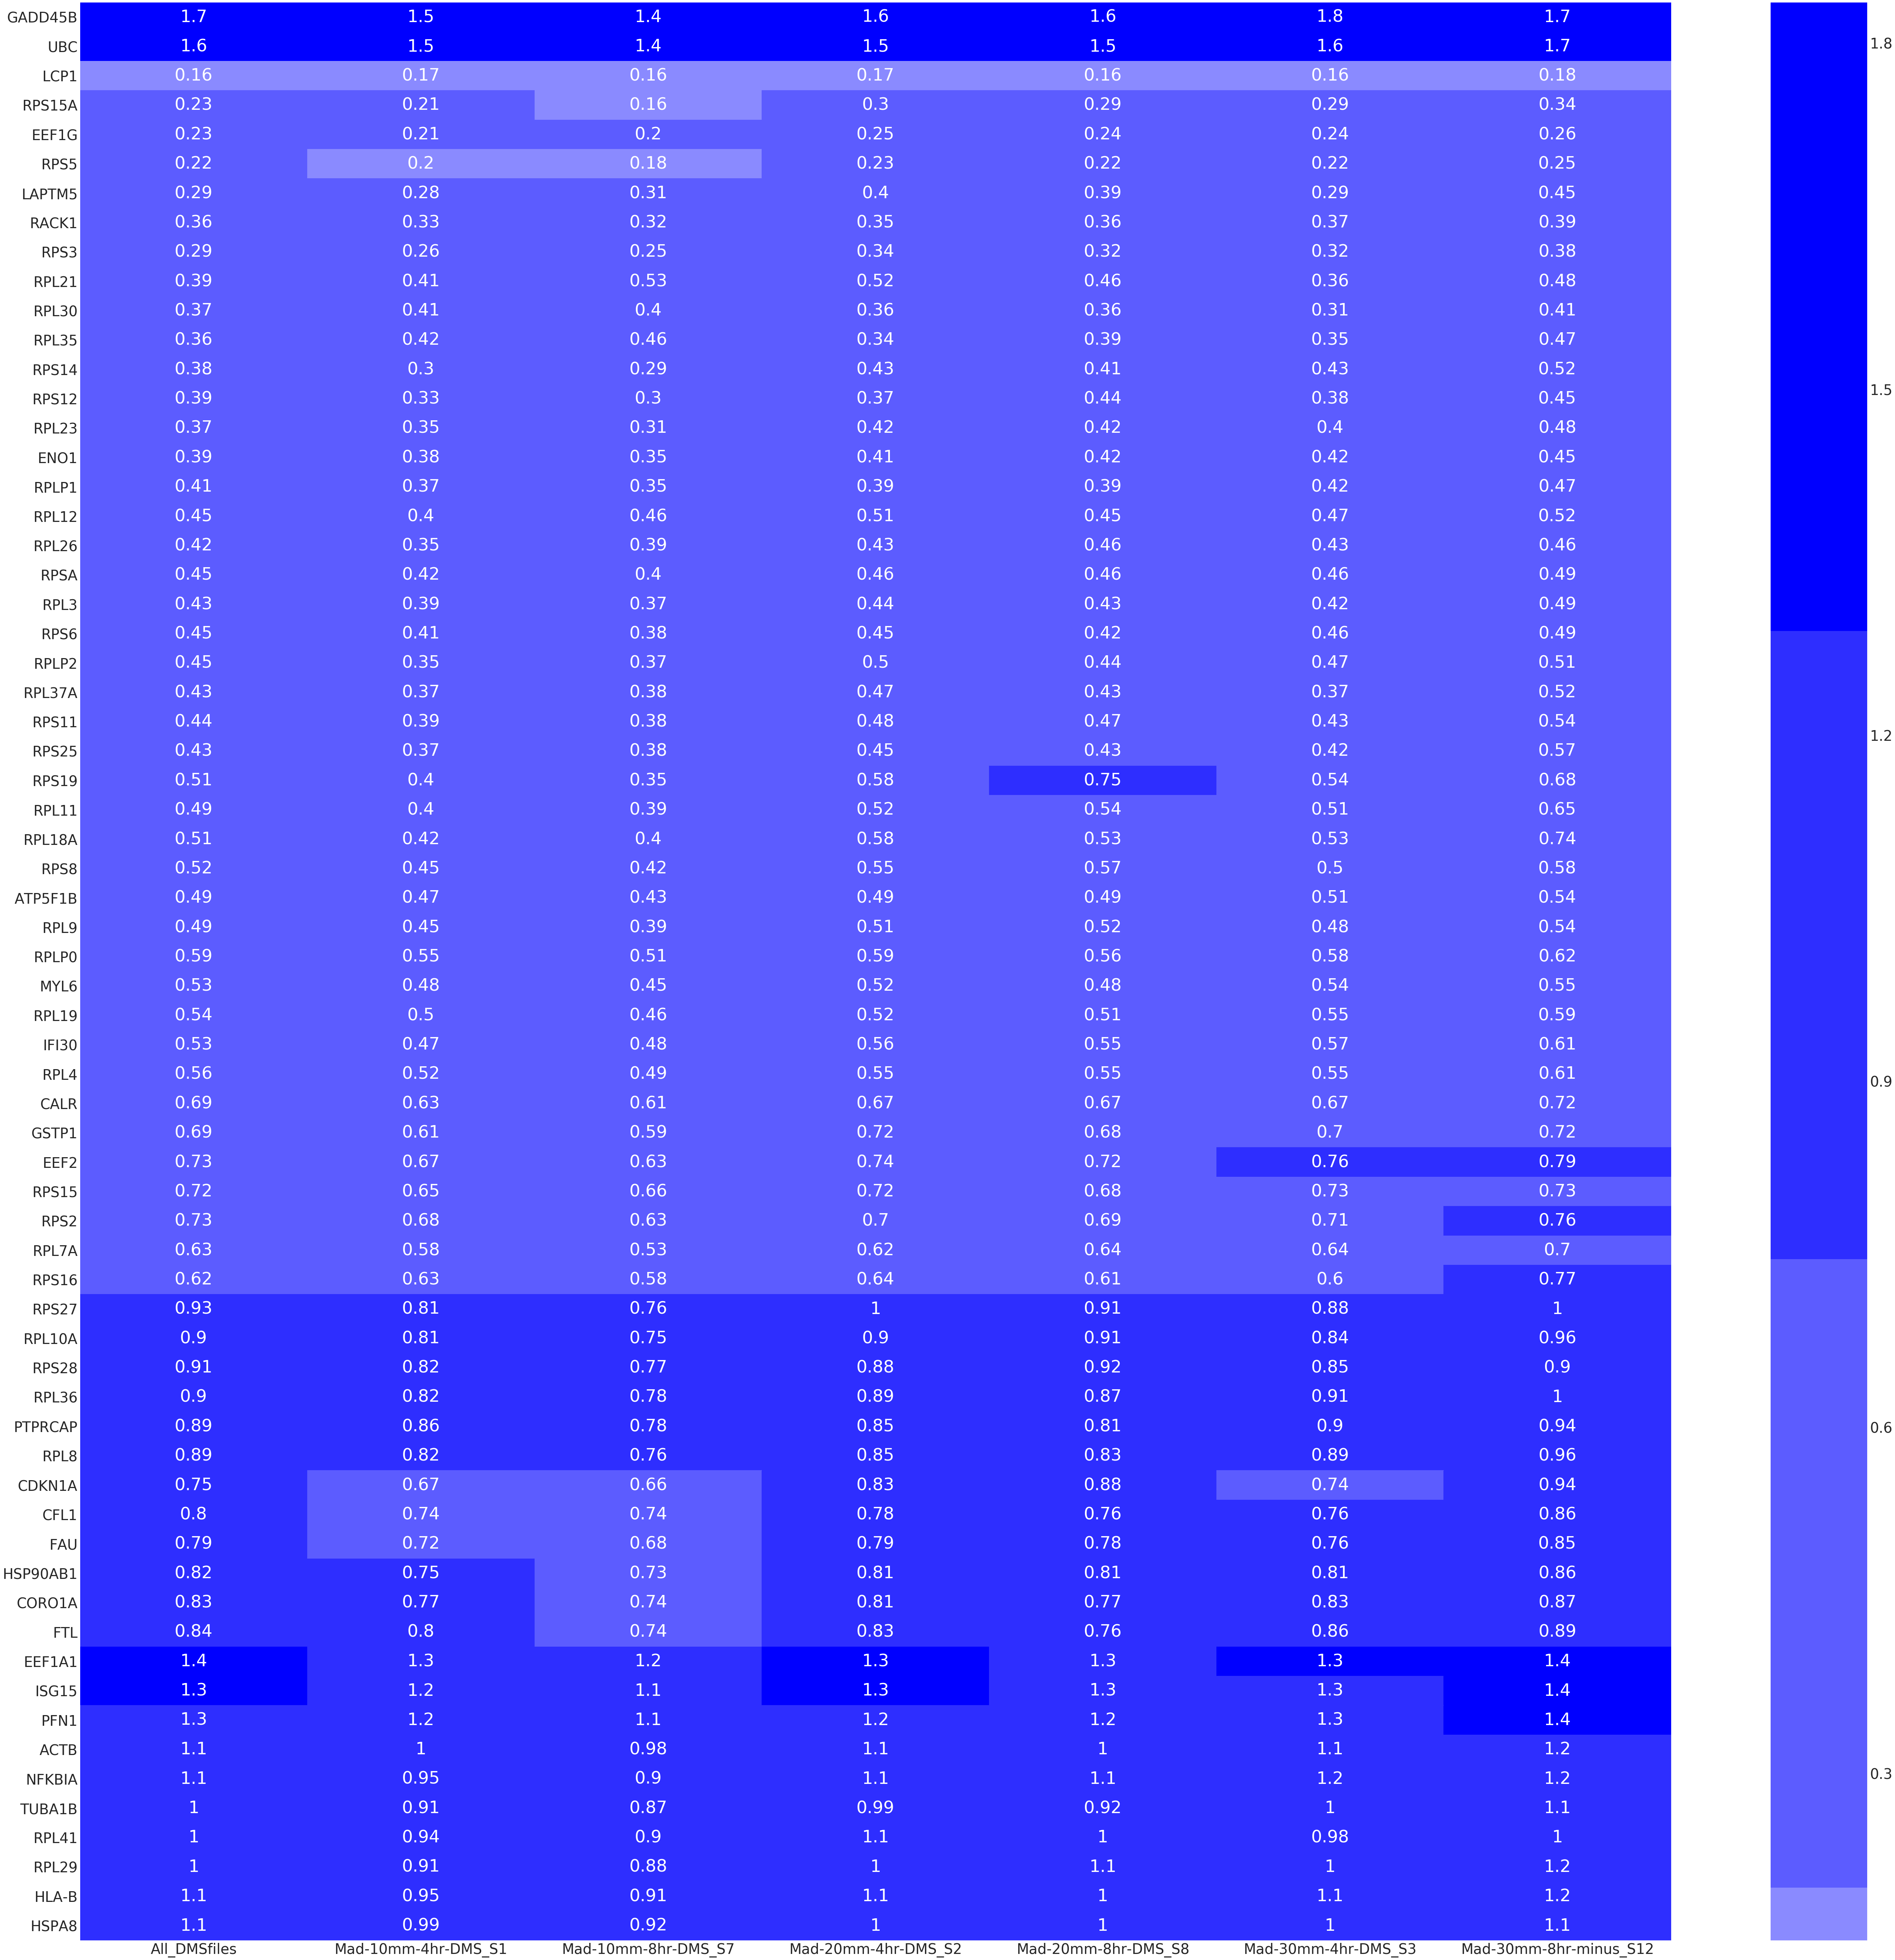

In [18]:
sns.set(font_scale=4)
fig, ax = plt.subplots(figsize=(100,100))
#sns.heatmap(ratios_readCounts_DMS,cmap="RdBu_r",vmax=1,vmin=0,yticklabels=True,center=0.5, ax=ax)
sns.heatmap(ratios_readCounts,cmap=sns.light_palette("blue"),yticklabels=True,annot=ratios_readCounts.values, ax=ax,center=0.2)
plt.savefig("../results/FeatureCounts_Ratio_TranscriptomeVsGenomicReads_PlusDMS_HeatMap_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")